In [2]:
import os
import sys

sys.path.append(os.path.abspath("../../"))


import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from plotnine import (
    aes,
    geom_text,
    geom_tile,
    ggplot,
    scale_x_discrete,
    xlab,
    ylab,
)
from sklearn.metrics import confusion_matrix, f1_score
from transformers import AutoConfig, AutoProcessor, AutoTokenizer

from utils.collator import SequenceGenerationCollator
from utils.dataset import IemocapDataset
from utils.model import MmLlamaConcat, MmLlamaConfig
from utils.processor import MmLlamaProcessor

# Early concatination

In [11]:
LANGUAGE_MODEL = os.path.abspath("../../models/language/LLaMA2-base")
LORA_ADAPTER = os.path.abspath("../../models/language/adapter/iemocap/LLaMA2-base")
ACOUSTIC_MODEL = os.path.abspath(
    "../../models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim"
)
DS_TRAIN_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
DS_DEV_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
DS_TEST_PATH = os.path.abspath("../../datasets/iemocap/iemocap.csv")
STAGE1_PATH = os.path.abspath(
    "../../experiments/multimodal/concat/iemocap/LLaMA2-base/mlp/audio_instruction/stage_1"
)
STAGE2_PATH = os.path.abspath(
    "../../experiments/multimodal/concat/iemocap/LLaMA2-base/mlp/audio_instruction/stage_1"
)


llm_config = AutoConfig.from_pretrained(LANGUAGE_MODEL)
ac_config = AutoConfig.from_pretrained(ACOUSTIC_MODEL)
ac_processor = AutoProcessor.from_pretrained(ACOUSTIC_MODEL)

# setup of tokenizer
tokenizer = AutoTokenizer.from_pretrained(LANGUAGE_MODEL)
tokenizer.add_special_tokens({"additional_special_tokens": ["<audio>"]})
tokenizer.pad_token_id = tokenizer.unk_token_id
tokenizer.padding_side = "left"

# setup of processor
processor = MmLlamaProcessor(ac_processor, tokenizer)

## setup of config
audio_token_id = tokenizer.additional_special_tokens_ids[0]
config = MmLlamaConfig(
    llm_config=llm_config,
    audio_config=ac_config,
    audio_token_id=audio_token_id,
    pad_token_id=tokenizer.pad_token_id,
    llm_pretrained_adapter=LORA_ADAPTER,
    num_labels=0,
)

model = MmLlamaConcat(config, output_attention_weights=True)
model.load_state_dict(torch.load(os.path.join(STAGE1_PATH, "best_model.pth")), strict=False)
model = model.apply_inference_lora(STAGE1_PATH)
if torch.cuda.is_available():
    model = model.to("cuda")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Unloading and merging model: 100%|██████████| 550/550 [00:02<00:00, 199.87it/s]
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at /home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Unloading and merging model: 100%|██████████| 582/582 [00:03<00:00, 157.01it/s]


####### Loaded adapter: /home/fock/code/MultiModalInstructERC/experiments/multimodal/concat/iemocap/LLaMA2-base/mlp/audio_instruction/stage_1 #######


In [94]:
def print_attention_weight_matrix(model:MmLlamaConcat, layer_idx = 0, sample_index = 0):
    test_dataset = IemocapDataset(DS_TEST_PATH, mode="test", task="normal", audio_placement="target")
    raw_sample = test_dataset[sample_index]
    print(raw_sample[0][1])
    sample = SequenceGenerationCollator(processor, mode="dev")([raw_sample])
    sample = sample[0]

    llama = model.llama
    att1 = llama.get_submodule(f"model.layers.{layer_idx}.self_attn")

    attention_weights = None

    def attention_hook(module, input, output):
        nonlocal attention_weights
        attention_weights = output[1]

    att_handle = att1.register_forward_hook(attention_hook)

    def prepate_nested_batch(batch:dict[dict[torch.Tensor]]):
        device ="cpu"
        if torch.cuda.is_available():
            device = "cuda"

        text = {k: v.to(device) for k, v in batch["text"].items()}
        acoustic = {k: v.half().to(device) for k, v in batch["acoustic"].items()}
        return {"text": text, "acoustic": acoustic}


    with torch.no_grad():
        _ = model(**prepate_nested_batch(sample))

    att_handle.remove()

    heads: np.ndarray = attention_weights[0].cpu().numpy()
    head_norm = heads.mean(axis=0)
    head_norm = np.apply_along_axis(lambda x: x / np.max(x), 1, head_norm)

    # print(heads.mean(axis=0))

    token_ids = sample["text"]["input_ids"][0].cpu().numpy()
    audio_loc = np.where(token_ids == audio_token_id)[0][0]
    token_ids = np.concatenate(
        (token_ids[:audio_loc], [audio_token_id] * 10, token_ids[audio_loc:])
    )
    token_strings = np.array(tokenizer.convert_ids_to_tokens(token_ids))
    # token_strings[token_ids == 0] = ""

    mean_attention = np.mean(head_norm, axis=0, where=head_norm != 0)
    # print(mean_attention)
    top_token_ids_idx = np.argsort(mean_attention)[::-1][:25]
    # print(top_token_ids_idx)
    # last_token_ids_idx = np.argsort(mean_attention)[:10]
    audio_loc_idx = np.where(token_ids == audio_token_id)[0]
    selected_tokens = np.unique(
        np.concatenate([top_token_ids_idx, audio_loc_idx])
    )
    token_strings[~np.isin(np.arange(len(token_strings)), selected_tokens)] = ""
    # print(token_strings)

    plt.figure(figsize=(10, 10))
    plt.imshow(head_norm, cmap="viridis")
    plt.xticks(range(len(token_strings)), token_strings, rotation=90, fontsize=6)
    plt.yticks(range(len(token_strings)), token_strings, fontsize=6)
    plt.xlabel("Query Tokens")
    plt.ylabel("Key Tokens")
    plt.show()
    

Now you are expert of sentiment and emotional analysis. The following conversation noted between '### ###' involves several speaker. ### Speaker_0: "Hi, I need an ID." ### Audio features of last utterance: <audio> Please select the emotional label of <Speaker_0: "Hi, I need an ID."> from <neutral, angry, frustrated, happy, excited, sad> based on both the context and audio features:


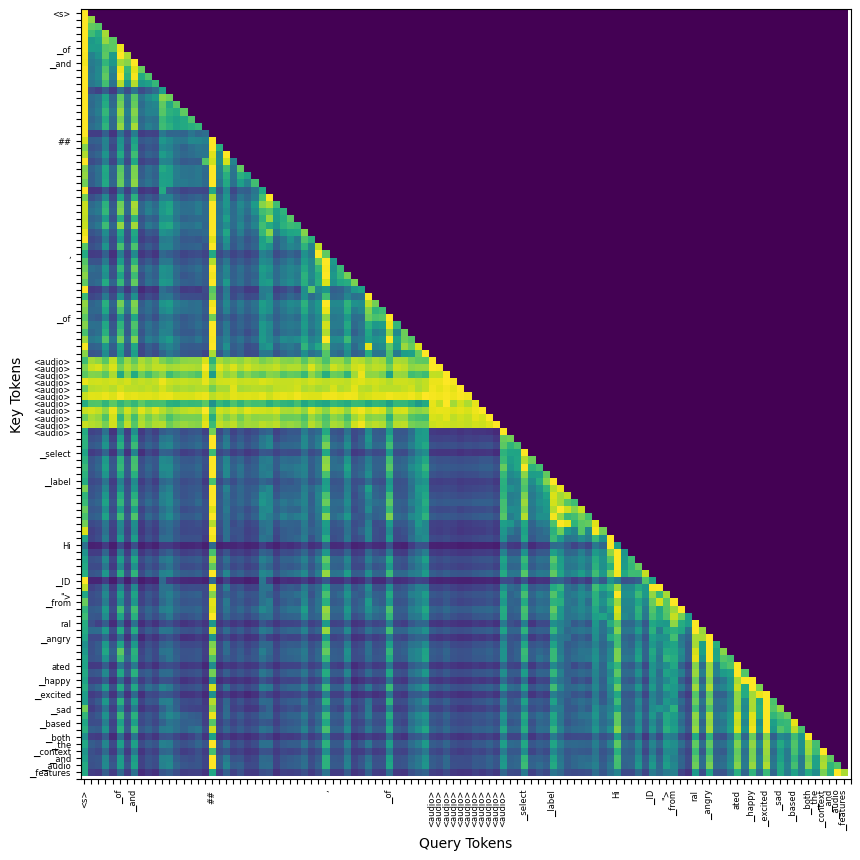

In [96]:
print_attention_weight_matrix(model, layer_idx = 0, sample_index = 0)

# Early Summation

**Auswertung auf IEMOCAP**

Fragen:
- Wird der Audio-Input akzeptiert?
  - Wie verändern sich die Inputvektoren?

## Wird die Akustik akzeptiert?

Dafür gucken wir uns zuerst die Projektionsmatrizen.
Der Projektor besteht aus zwei Matrizen $P_1 \in \mathbb{R}^{d_a \times d_a}, P_2 \in \mathbb{R}^{d_a \times d_t}$. Interessant ist $P_2$, da diese den finalen input liefert.

In [3]:
state_dict = torch.load("../../experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/enclose_both_utterances/stage_2/best_model.pth", map_location="cpu")
p2_weights: torch.Tensor = state_dict["projector.proj2.weight"]
p2_bias: torch.Tensor = state_dict["projector.proj2.bias"]

weight_std = p2_weights.std().item()
bias_std = p2_bias.std().item()
weight_mean = p2_weights.mean().item()
bias_mean = p2_bias.mean().item()


print(f"Mittelwert der Gewichte = {weight_mean:.3f}")
print(f"Mittelwert der Biase = {bias_mean:.3f}")
print(f"Streuung der Gewichte = {weight_std:.3f}")
print(f"Streuung der Biase = {bias_std:.3f}")

Mittelwert der Gewichte = -0.000
Mittelwert der Biase = -0.000
Streuung der Gewichte = 0.019
Streuung der Biase = 0.019


Die Gewichte und Bias streuen maginal um 0. Das lässt darauf schließen, dass das Modell den Input auf 0 runter zieht, um die überlegene Leistung des Textes nicht zu beeinflussen.

Die Akustik wird also nicht angenommen, sondern als störendes Rauschen wargenommen

# Late Fusion (Summation)

**Auswertung auf IEMOCAP**

Zuerst werden die aktuellen Ergebnisse analysiert.
Die Ergebnisse von audio-only stammen aus dem mit nur auf audio vortrainiertem Modell, während text-only das finale Modell mit genulltem Audiosignal ist.
Fragen, die zu beantworten sind:
- Wie ist die Differenz zwischen text-/audio-only in der Klassifizierung?
  - Wie sicher war sich das Modell bei der klassifizierung?
  - kann das Modell Datenpunkte erkennen, die es nur mit beiden inputs richtig erkennt?
- Wie verhält sich der Gating-Mechanismus?
- wie ist der best mögliche F1 score, wenn das Modell 100% der beiden Teilmodelle ausnutzen könnte?
- Welche Klassen werden häufig verwechselt?
  - bei Text-only
  - bei Audio-only
- Gibt es besonderheiten in den Ausdrücken, wenn sie nur von Audio richtig klassifiziert werden?

In [3]:
base_path = "./results/late_fusion/loss_gate"

text_only_p = os.path.join(base_path, "preds_test_no_audio.json")
audio_only_p = os.path.join(base_path, "preds_test_no_text.json")
both_p = os.path.join(base_path, "preds_test.json")


with open(text_only_p, "rt") as f:
    text_only = json.load(f)

with open(audio_only_p, "rt") as f:
    audio_only = json.load(f)

with open(both_p, "rt") as f:
    both = json.load(f)

results = (
    pd.DataFrame.from_records(text_only, index=["index"])
    .merge(
        pd.DataFrame.from_records(audio_only, index=["index", "input", "target"]),
        on=["index"],
        suffixes=["_text", "_audio"],
    )
    .merge(
        pd.DataFrame.from_records(both, index=["index", "input", "target"]),
        on=["index"],
        suffixes=["_both"],
    )
)
assert len(results) == len(text_only)
results["utterance"] = results["input"].str.extract('<Speaker_\d: "(.*?)">')

import re


def get_dialog(prompt: str) -> tuple[list[str], set[str]]:
    base_prompt = "Now you are expert of sentiment and emotional analysis. The following conversation noted between '### ###' involves several speaker."
    prompt = prompt.replace(base_prompt, "")
    dialouge = re.findall(r"###(.*)###", prompt)[0].strip()
    dialog_text = re.findall(
        r"Speaker_\d:\s?\"(.*?)(?=\"\s?\t|\"\s?$)", dialouge, re.MULTILINE
    )
    involved_speakers = set(re.findall(r"(Speaker_\d)", dialouge))
    return dialog_text, involved_speakers


results["dialouge_length"] = results["input"].apply(lambda x: len(get_dialog(x)[0]))
results["utterence_length"] = results["utterance"].apply(lambda x: len(x.split()))



def sigmoid(x: float) -> float:
    return 1 / (1 + np.exp(-x))


def softmax(x: list[float]) -> list[float]:
    return np.exp(x) / np.sum(np.exp(x))


# results["gates"] = results["gates"].apply(lambda x: softmax(x))
results["text_gate"] = results["gates"].apply(lambda x: x[0])
results["audio_gate"] = results["gates"].apply(lambda x: x[1])

results

,input,output_text,target,certainty_text,gates_text,output_audio,certainty_audio,gates_audio,output,certainty,gates,utterance,dialouge_length,utterence_length,text_gate,audio_gate
index,,,,,,,,,,,,,,,,
0,Now you are expert of sentiment and emotional ...,frustrated,neutral,0.470215,"[-0.36181640625, 0.599609375]",neutral,0.562012,"[-2.935546875, 0.3798828125]",neutral,0.574219,"[1.177734375, 0.46533203125]","Hi, I need an ID.",1,5,1.177734,0.465332
1,Now you are expert of sentiment and emotional ...,neutral,neutral,0.842773,"[-0.342041015625, 0.81396484375]",neutral,0.504395,"[-3.5078125, 0.705078125]",neutral,0.832031,"[1.5498046875, 0.450927734375]","ahh Yeah, this is the wrong line. I'm sorry. ...",2,26,1.549805,0.450928
2,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.872559,"[0.595703125, -0.1949462890625]",neutral,0.477539,"[-3.173828125, 0.07958984375]",frustrated,0.719238,"[1.9609375, 0.27490234375]","Okay, I'm sorry, but I just stood in this line...",3,21,1.960938,0.274902
3,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.890625,"[0.0156707763671875, -0.287353515625]",neutral,0.412842,"[-3.599609375, 0.04681396484375]",frustrated,0.835449,"[1.748046875, 0.197509765625]","No, they told me-I'm sorry, but they told me t...",5,14,1.748047,0.197510
4,Now you are expert of sentiment and emotional ...,frustrated,frustrated,0.898926,"[0.06744384765625, -0.31640625]",neutral,0.608887,"[-3.341796875, 0.0185394287109375]",frustrated,0.828125,"[1.697265625, 0.18359375]","What, I mean what... what's the difference? W...",7,19,1.697266,0.183594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,Now you are expert of sentiment and emotional ...,angry,angry,0.892090,"[-1.369140625, 0.505859375]",angry,0.884766,"[-3.478515625, 1.15234375]",angry,0.965332,"[0.125244140625, -0.099609375]",oh! Marry you again? I wouldn't marry you agai...,12,18,0.125244,-0.099609
1618,Now you are expert of sentiment and emotional ...,angry,angry,0.853516,"[-0.9970703125, 0.23291015625]",excited,0.444580,"[-2.806640625, 0.73876953125]",angry,0.904297,"[0.437255859375, -0.419189453125]",Beast,12,1,0.437256,-0.419189
1619,Now you are expert of sentiment and emotional ...,angry,angry,0.901855,"[-1.525390625, 0.61083984375]",angry,0.910645,"[-3.580078125, 1.380859375]",angry,0.958496,"[-0.165771484375, 0.137939453125]",You're a wicked little vampire. And I pray to...,12,22,-0.165771,0.137939


## Wie ist die Differenz zwischen text-/audio-only in der Klassifizierung?

In [4]:
text_only_correct = results[(results["output_text"] == results["target"]) & (results["output_audio"] != results["target"])]
audio_only_correct = results[(results["output_text"] != results["target"]) & (results["output_audio"] == results["target"])]
both_only_correct = results[(results["output"] == results["target"]) & (results["output_audio"] != results["target"]) & (results["output_text"] != results["target"])]
text_correct_but_not_both = results[(results["output_text"] == results["target"]) & (results["output"] != results["target"])]
audio_correct_but_not_both = results[(results["output_audio"] == results["target"]) & (results["output"] != results["target"])]
text_correct_but_not_audio_and_both = results[(results["output_text"] == results["target"]) & (results["output_audio"] != results["target"]) & (results["output"] != results["target"])]
audio_correct_but_not_text_and_both = results[(results["output_text"] != results["target"]) & (results["output_audio"] == results["target"]) & (results["output"] != results["target"])]

print(f"es konnten {len(text_only_correct)} Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only")
print(f"es konnten {len(audio_only_correct)} Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only")
print(f"es konnten {len(both_only_correct)} Datenpunkte nur durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(text_correct_but_not_both)} Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(audio_correct_but_not_both)} Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(text_correct_but_not_audio_and_both)} Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input erkannt werden")
print(f"es konnten {len(audio_correct_but_not_text_and_both)} Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input erkannt werden")


es konnten 486 Datenpunkte nur vom text-only Modell erkannt werden, nicht aber vom audio-only
es konnten 175 Datenpunkte nur vom audio-only Modell erkannt werden, nicht aber vom text-only
es konnten 39 Datenpunkte nur durch gemeinsamen Input erkannt werden
es konnten 65 Datenpunkte nur durch text-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden
es konnten 112 Datenpunkte nur durch audio-only erkannt werden, nicht aber durch gemeinsamen Input erkannt werden
es konnten 61 Datenpunkte nur durch text-only erkannt werden, aber weder durch audio-only noch durch gemeinsamen Input erkannt werden
es konnten 108 Datenpunkte nur durch audio-only erkannt werden, aber weder durch text-only noch durch gemeinsamen Input erkannt werden


Daraus lässt sich in Bezug auf die zusätzliche Modalität folgern:
- Audio-Input darf nicht vernachlässigt werden, da 175 Beispiele nur von der Akustik korrekt klassifiziert werden konnte, nicht aber vom Text
- Audio wird aber stark unterdrückt. von den 175, die nur von der Akustik erkannt werden konnten, werden 112 weiterhin nicht erkannt, wenn der Text hinzukommt.

## Wie verhält sich der Gating-Mechanismus?

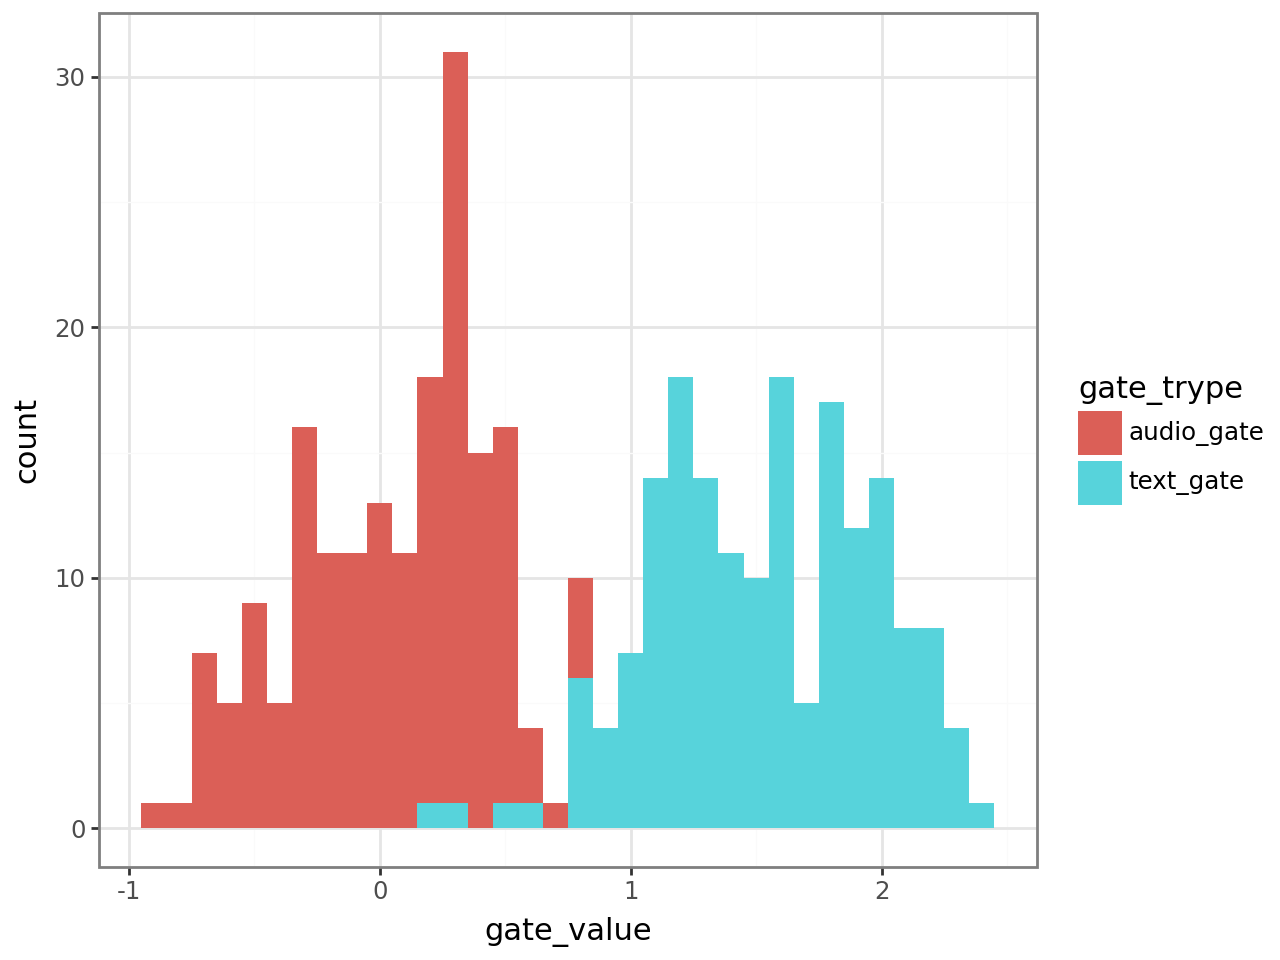

In [5]:
from plotnine import geom_histogram, theme_bw

(
    ggplot(audio_only_correct.melt(value_vars=["text_gate", "audio_gate"], var_name="gate_trype", value_name="gate_value"), aes(x="gate_value", fill="gate_trype")) +
    # geom_density(alpha=0.5) +
    geom_histogram(binwidth=0.1) +
    # xlim(0, 1) + 
    theme_bw()
)

## Idealer F1 Score
Dafür wird der F1 Score zwischen der Verknüpfung $(y_t = y) \vee (y_a = y) \vee (y_b = y)$ und $y$ berechnet.
Für die übrig bleibenden / überall falschen Felder, wird das Ergebnis vom gemischten Modell eingetragen. Dies hat aber keinen Einfluss auf den F1 Score

In [6]:
results["any_correct"] = results[(results["output_text"] == results["target"]) | (results["output_audio"] == results["target"]) | (results["output"] == results["target"])]["target"]
results.loc[results["any_correct"].isna(), "any_correct"] = results.loc[results["any_correct"].isna(), "output"]

f1 = f1_score(results["target"], results["output"], average="weighted")
text_f1 = f1_score(results["target"], results["output_text"], average="weighted")
audio_f1 = f1_score(results["target"], results["output_audio"], average="weighted")
ideal_f1 = f1_score(results["target"], results["any_correct"], average="weighted")

print(f"Model F1 Score: {f1:.3f}")
print(f"Text F1 Score: {text_f1:.3f}")
print(f"Audio F1 Score: {audio_f1:.3f}")
print(f"Idealer F1 Score: {ideal_f1:.3f}")

Model F1 Score: 0.715
Text F1 Score: 0.690
Audio F1 Score: 0.486
Idealer F1 Score: 0.821


Wäre das Modell in der Lage die Teilmodelle (Akustik- und Sprachmodell) perfekt einzusetzen, wäre ein theoretischer F1-Score von 0.808 möglich, angenommen keine weiteren Beispiele lassen sich nur durch gemeinsamen Input klassifizieren.

## Confusion Matrix

In [7]:
from plotnine import scale_color_manual, scale_fill_cmap

target_labels = results["target"].value_counts().index.to_list()[::-1]


def print_confusion_matrix(
    results: pd.DataFrame,
    target_labels: list[str] | None = None,
    output_column: str = "output",
) -> None:
    target_labels = (
        results["target"].unique() if target_labels is None else target_labels
    )
    cm = confusion_matrix(results["target"], results[output_column], labels=target_labels)
    cm_df = pd.DataFrame(cm, index=target_labels, columns=target_labels)
    cm_melted = cm_df.reset_index().melt(id_vars="index", value_name="count")
    cm_melted.columns = ["actual", "predicted", "count"]
    cm_melted["actual"] = pd.Categorical(cm_melted["actual"], categories=target_labels)
    cm_melted["predicted"] = pd.Categorical(
        cm_melted["predicted"], categories=target_labels
    )

    # Calculate total counts for each actual class
    total_counts = cm_melted.groupby("actual")["count"].sum().reset_index()
    total_counts.columns = ["actual", "total_count"]

    # Merge total counts back to the melted DataFrame
    cm_melted = cm_melted.merge(total_counts, on="actual")

    # Calculate the fraction
    cm_melted["sqrt_fraction"] = np.sqrt(cm_melted["count"]) / np.sqrt(cm_melted["total_count"])
    cm_melted["fraction"] = (cm_melted["count"] / cm_melted["total_count"]).round(2)
    cm_melted["label"] = cm_melted["count"].astype(str) + " (" + cm_melted["fraction"].astype(str) + ")"
    cm_melted["p_group"] = cm_melted["fraction"].apply(lambda x: "high" if x > 0.5 else "low")

    p = (
        ggplot(cm_melted, aes("factor(predicted)", "factor(actual)", fill="sqrt_fraction"))
        + geom_tile(show_legend=False)
        + geom_text(aes(label="label", color="p_group"), size=8, show_legend=False)
        + ylab("Predicted")
        + xlab("True")
        + scale_x_discrete(limits=target_labels[::-1])
        + scale_fill_cmap(cmap_name="magma")
        + scale_color_manual(["black", "white"])
    )

    p.show()

Die Confusion Matrix enthät neben der absoluten Anzahl auch das Verhältnis in der entsprechenden Reihe

**Confusion Matrix vom text-only Modell**

/tmp/ipykernel_4013234/402107308.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


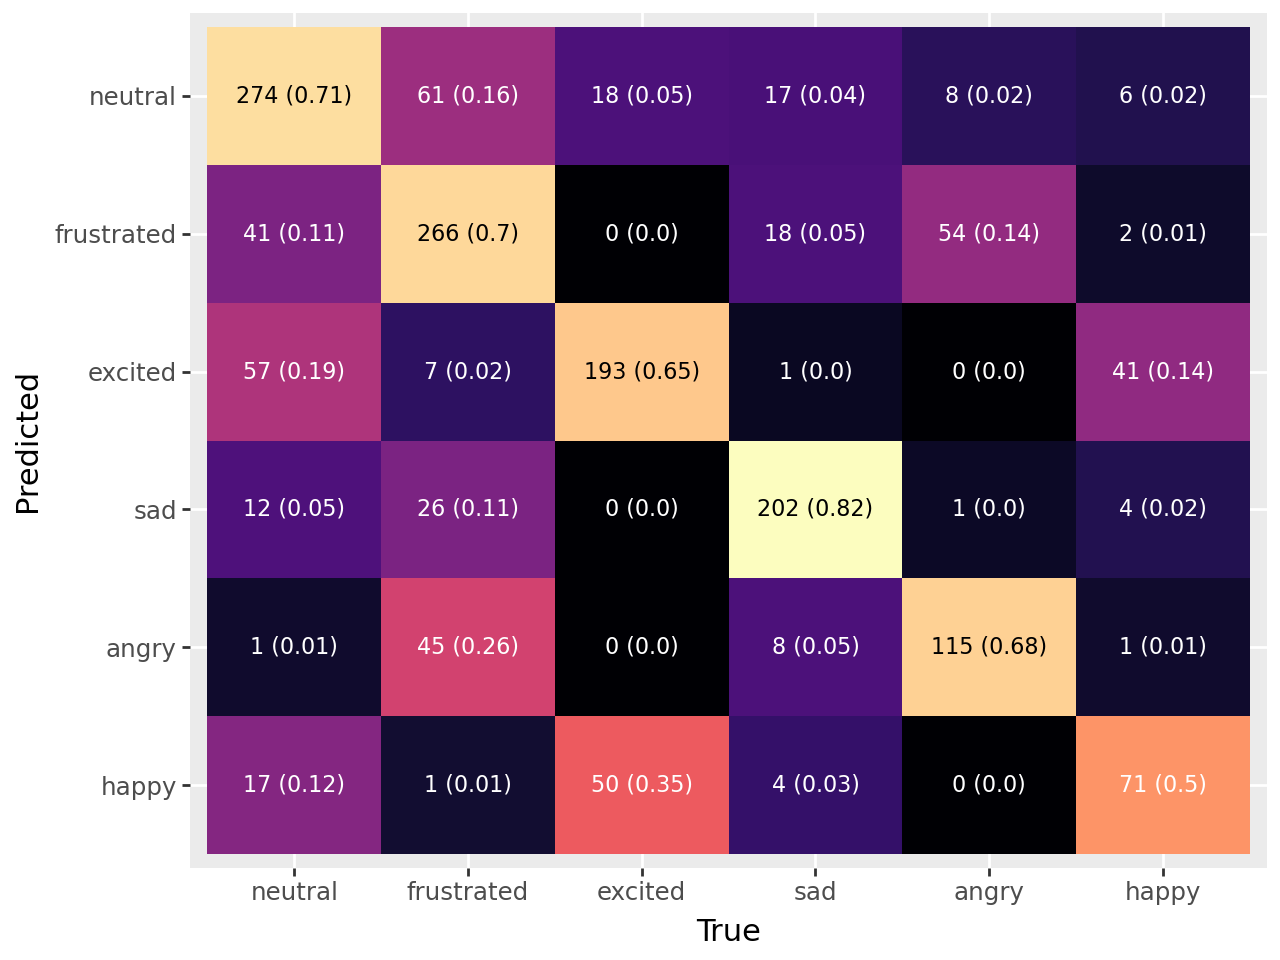

In [8]:
print_confusion_matrix(results, target_labels, output_column="output_text")

- Die meisten verwechselungen gibt es mit "neutral"
- Nah beieinander liegende Emotionen werden oft verwechselt
  - "excited" mit "happy"
  - "angry" mit "frustrated"

**Confisuin Matrix vom audio-only Modell**

/tmp/ipykernel_4013234/402107308.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


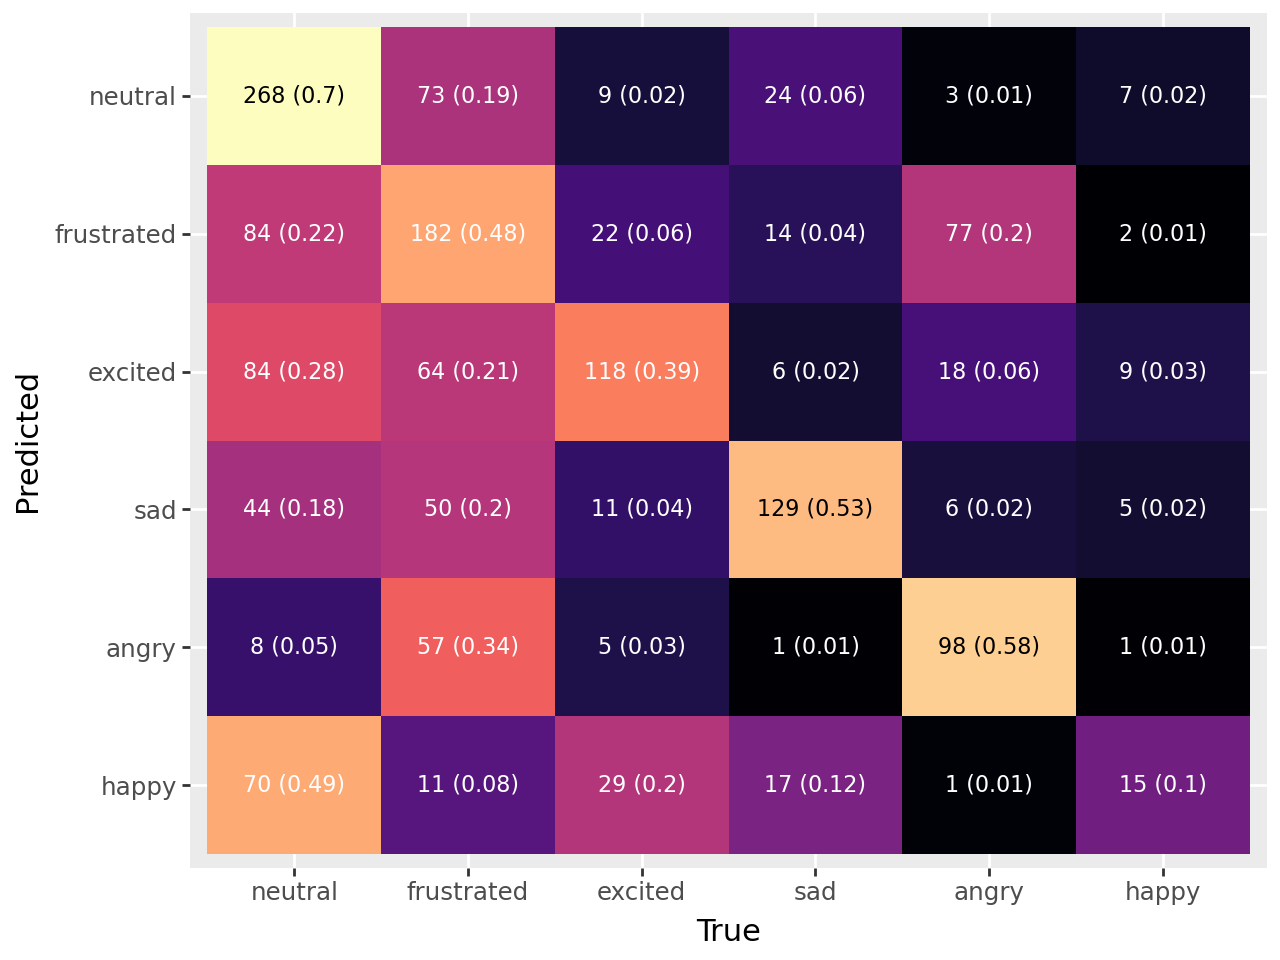

In [9]:
print_confusion_matrix(results, target_labels, output_column="output_audio")

Hier stellt sich ein ähnliches Bild, wie beim text ein, nur, dass die Werte stärker verteilt sind (niedrigerer F1)

**Confusion Matrix vom kombinierten Modell**

/tmp/ipykernel_4013234/402107308.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


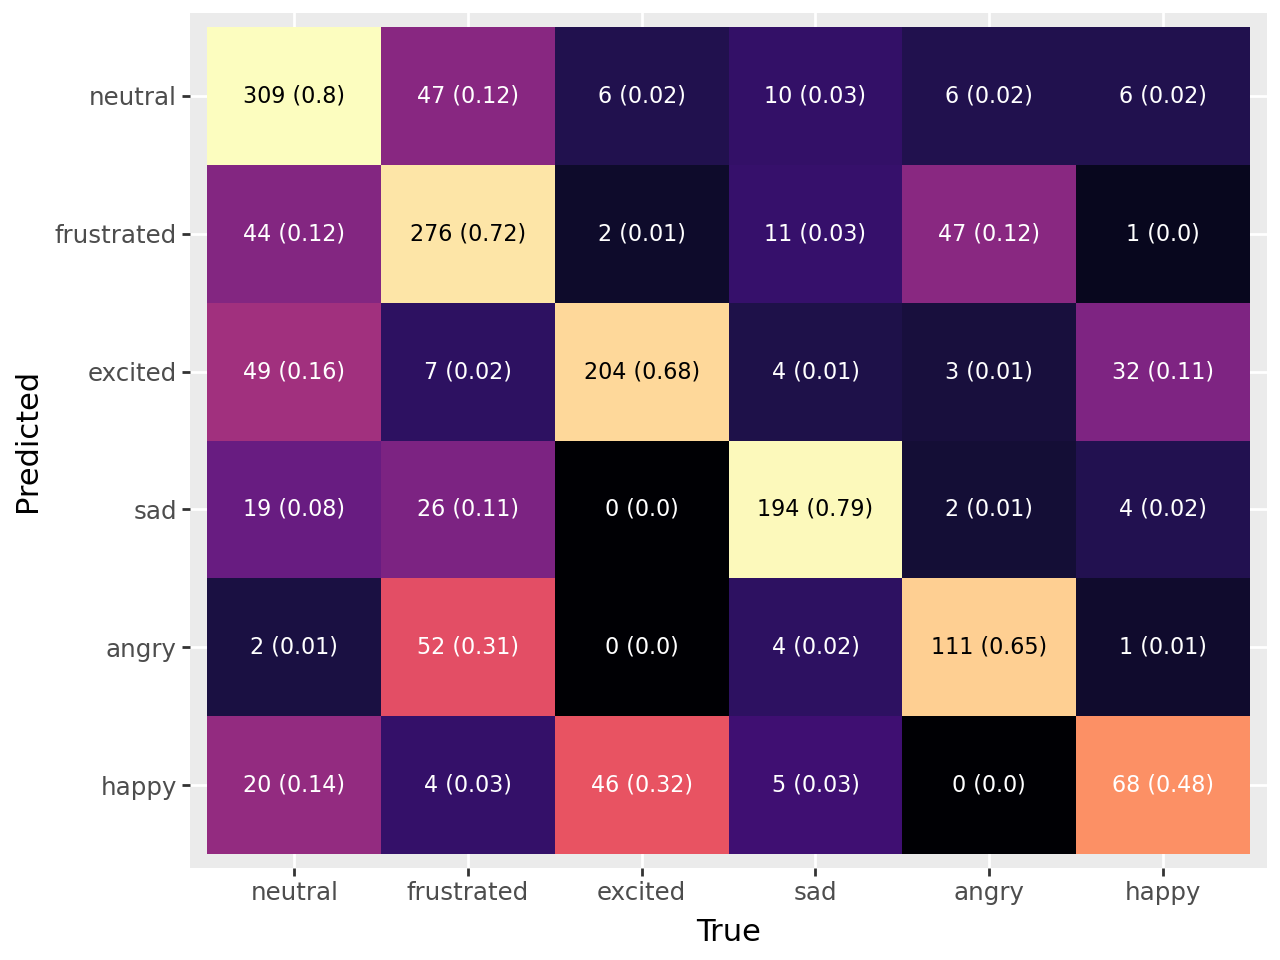

In [10]:
print_confusion_matrix(results, target_labels, output_column="output")

## Gibt es besonderheiten in den Ausdrücken, wenn sie nur von Audio richtig klassifiziert werden?
Diese Frage zielt darauf ab, ob man im vorhinein erkennen kann, ob die Klassifizierung mittels Audio oder Text vielversprechender ist

**Verteilung der Dialoglängen**

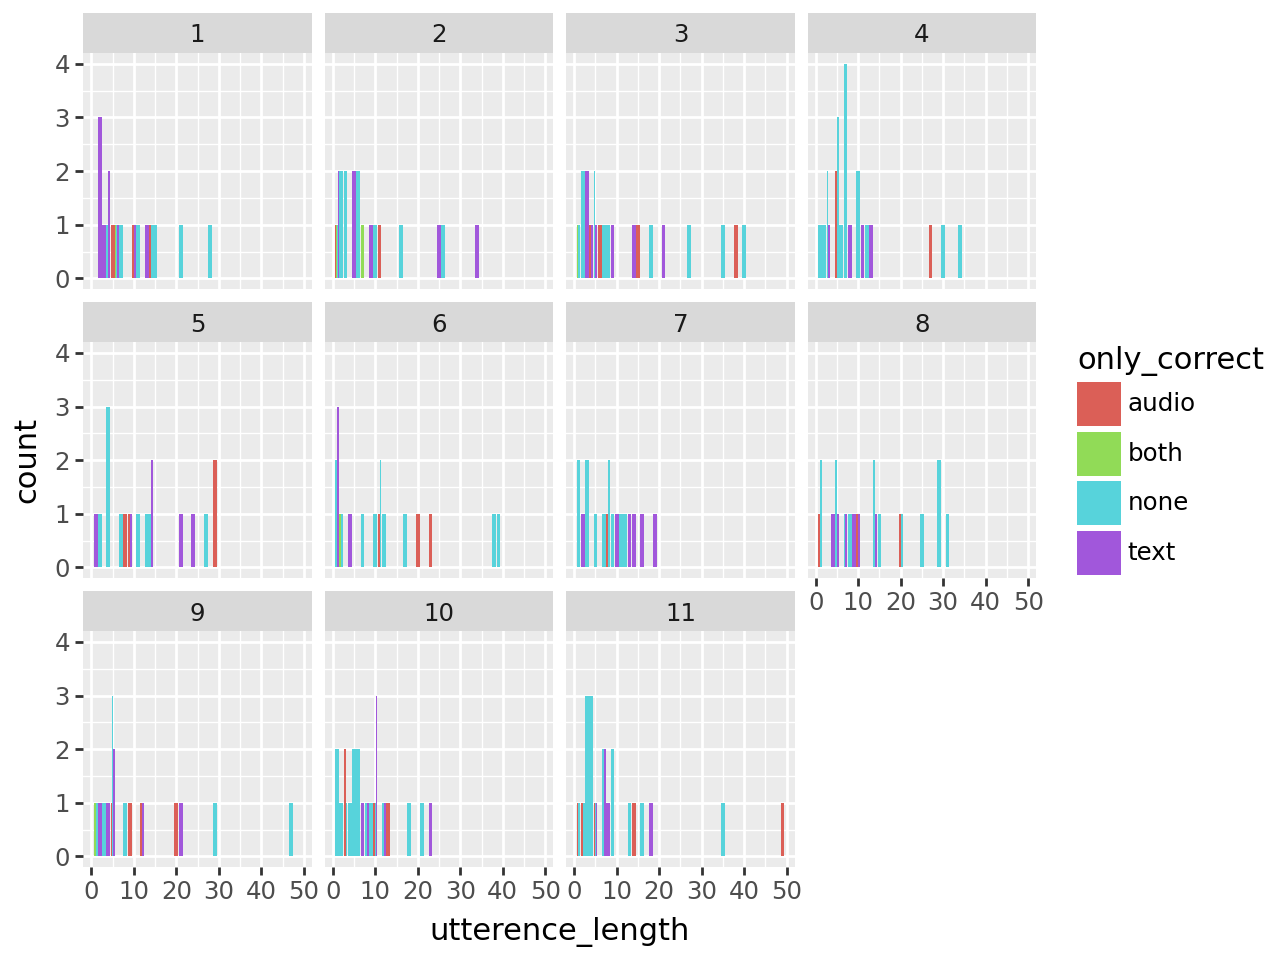

In [11]:
from plotnine import facet_wrap, geom_histogram

results.loc[text_only_correct.index, "only_correct"] = "text"
results.loc[audio_only_correct.index, "only_correct"] = "audio"
results.loc[both_only_correct.index, "only_correct"] = "both"
results["only_correct"] = results["only_correct"].fillna("none")

(
    ggplot(results[(results["dialouge_length"] < 12) & (results["utterence_length"] < 50)].dropna(), aes(x="utterence_length", fill="only_correct")) +
    geom_histogram(stat="count", position="dodge") + 
    # geom_density(stat="count", alpha=0.33) + 
    facet_wrap("dialouge_length")
)

